## **DL_Pythorch_diabetes_Classification**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
import pandas as pd
import os

# 데이터 불러오기
file_name = 'diabetes.csv'
full_file_path = os.path.join(os.getcwd() + "\\" + file_name)
df = pd.read_csv(full_file_path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# 결측치 확인
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
# 레이블 확인
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [5]:
from sklearn.preprocessing import StandardScaler

# 피처, 레이블 데이터 나누기
X = df.drop('Outcome', axis = 1).values
y = df['Outcome'].values

# 데이터 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((614, 8), (154, 8), (614,), (154,))

In [7]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.int64)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.int64)

In [8]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

In [10]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # 2 classes in the dataset
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [12]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6446, Accuracy: 70.13%
Epoch 2/20, Loss: 0.5800, Accuracy: 76.62%
Epoch 3/20, Loss: 0.5283, Accuracy: 76.62%
Epoch 4/20, Loss: 0.5077, Accuracy: 77.92%
Epoch 5/20, Loss: 0.5008, Accuracy: 77.92%
Epoch 6/20, Loss: 0.4642, Accuracy: 78.57%
Epoch 7/20, Loss: 0.4635, Accuracy: 80.52%
Epoch 8/20, Loss: 0.4521, Accuracy: 78.57%
Epoch 9/20, Loss: 0.4508, Accuracy: 79.87%
Epoch 10/20, Loss: 0.4526, Accuracy: 79.87%
Epoch 11/20, Loss: 0.4342, Accuracy: 81.17%
Epoch 12/20, Loss: 0.4553, Accuracy: 79.87%
Epoch 13/20, Loss: 0.4383, Accuracy: 81.82%
Epoch 14/20, Loss: 0.4396, Accuracy: 79.87%
Epoch 15/20, Loss: 0.4268, Accuracy: 79.22%
Epoch 16/20, Loss: 0.4205, Accuracy: 80.52%
Epoch 17/20, Loss: 0.4073, Accuracy: 81.82%
Epoch 18/20, Loss: 0.4146, Accuracy: 81.17%
Epoch 19/20, Loss: 0.4105, Accuracy: 82.47%
Epoch 20/20, Loss: 0.4200, Accuracy: 81.82%
Training complete.


In [ ]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average = 'weighted')
precision = precision_score(all_labels, all_predictions, average = 'weighted')
recall = recall_score(all_labels, all_predictions, average = 'weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[93 14]
 [14 33]]
F1 Score: 0.82
Precision: 0.82
Recall: 0.82
Specificity: 0.79


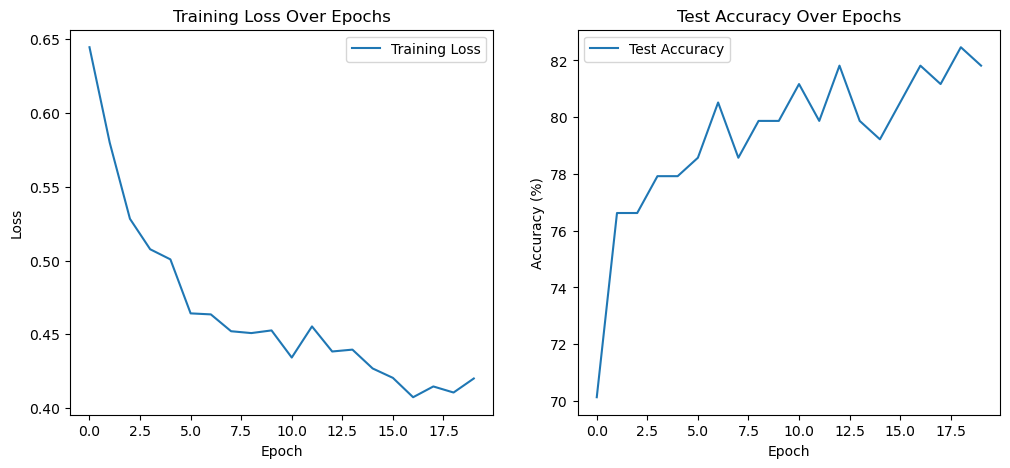

In [14]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()